# AlexNet

This notebook is for the blog: [AlexNet: The Breakthrough CNN](https://derekzhouai.github.io/posts/building-alexnet-for-mnist/)

## Model Implementation

In [ ]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Layer #1
            nn.Conv2d(1, 96, kernel_size=11, stride=4),    # 1x224x224 → 96x54x54
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),         # 96x54x54 → 96x26x26

            # Layer #2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 96x26x26 → 256x26x26
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),         # 256x26x26 → 256x12x12

            # Layer #3
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 256x12x12 → 384x12x12
            nn.ReLU(),

            # Layer #4
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 384x12x12 → 384x12x12
            nn.ReLU(),

            # Layer #5
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 384x12x12 → 256x12x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),         # 256x12x12 → 256x5x5

            nn.Flatten(),                                  # 256x5x5 → 6400

            # Layer #6
            nn.Linear(256 * 5 * 5, 4096),                  # 6400 → 4096
            nn.ReLU(),
            nn.Dropout(),

            # Layer #7
            nn.Linear(4096, 4096),                         # 4096 → 4096
            nn.ReLU(),
            nn.Dropout(),

            # Layer #8 (Output)
            nn.Linear(4096, num_classes)                   # 4096 → 10
        )

    def forward(self, x):
        return self.net(x)

## Model Training

### Preparing the Data

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_data_loaders(batch_size=128):
    transform = transforms.Compose([
        transforms.Resize(224),    # Upscale 28x28 → 224x224
        transforms.ToTensor()
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader = get_data_loaders(batch_size=128)
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 60000
Number of test samples: 10000


In [4]:
X, y = next(iter(train_loader))
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: torch.Size([128, 1, 224, 224])
y.shape: torch.Size([128])


### Training the Model

In [5]:
import torch

def evaluate(model, loader, loss, device):
    model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            y_hat = model(X)
            l = loss(y_hat, y)

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)
            
    return total_loss / total_num, total_correct / total_num

In [6]:
def train(model, num_epochs, batch_size, lr, device):
    model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    train_loader, test_loader = get_data_loaders(batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_num = 0.0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
        
            optimizer.zero_grad()
            y_hat = model(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            total_loss += l.item() * X.size(0)
            total_correct += (y_hat.argmax(dim=1) == y).sum().item()
            total_num += X.size(0)

        train_loss = total_loss / total_num
        train_acc = total_correct / total_num

        test_loss, test_acc = evaluate(model, test_loader, loss, device)
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train => Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Test => Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

In [14]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
model = AlexNet()
num_epochs = 10
batch_size = 128
lr = 0.1

# train(model, num_epochs, batch_size, lr, device)

## Model Testing

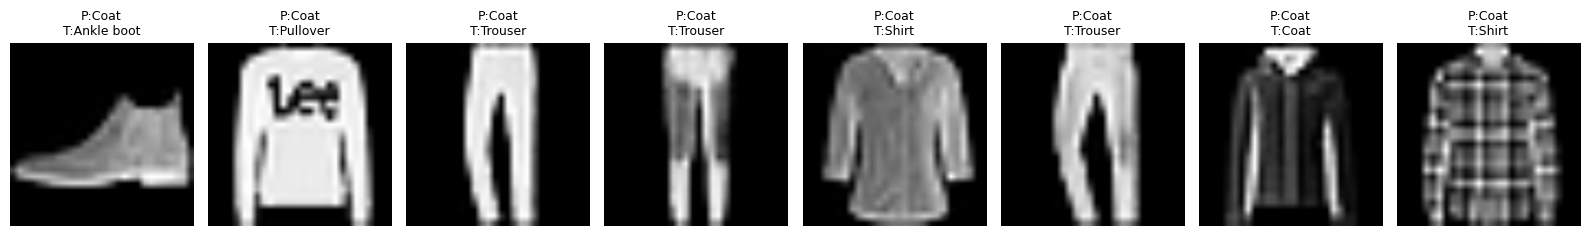

In [ ]:
import torch
import matplotlib.pyplot as plt

# FashionMNIST class names
FASHION_CLASSES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_fashionmnist_preds(model, test_loader, device, n=8):
    """
    Show n FashionMNIST test images with predicted and true labels.
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        X, y = next(iter(test_loader))
        X, y = X[:n], y[:n]
        pred = model(X.to(device)).argmax(1).cpu()

    plt.figure(figsize=(2*n, 2.6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        img = X[i].squeeze().cpu()
        plt.imshow(img, cmap="gray")
        p_idx, t_idx = pred[i].item(), y[i].item()
        plt.title(f"P:{FASHION_CLASSES[p_idx]}\nT:{FASHION_CLASSES[t_idx]}", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_fashionmnist_preds(model, test_loader, device, n=8)